##### Copyright 2021 The TensorFlow Authors.

In [152]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/audio/transfer_learning_audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF 허브 모델 보기</a></td>
</table>

# 환경 소리 분류를 위한 YAMNet을 사용한 전이 학습

[YAMNet](https://tfhub.dev/google/yamnet/1)은 웃음, 짖음 또는 사이렌과 같은 [521개 클래스](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv)의 오디오 이벤트를 예측할 수 있는 사전 훈련된 심층 신경망입니다.

이 튜토리얼에서는 다음 방법을 배웁니다.

- 추론을 위해 YAMNet 모델을 로드하고 사용합니다.
- 고양이와 개 소리를 분류하기 위해 YAMNet 임베딩을 사용하여 새 모델을 빌드합니다.
- 모델을 평가하고 내보냅니다.


## 텐서플로와 추가 라이브러리 임포트


디스크에서 오디오 파일을 더 쉽게 로드할 수 있도록 우선 [TensorFlow I/O](https://www.tensorflow.org/io)를 설치합니다.

In [153]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"

In [154]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## YAMNet 소개

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet)은 [MobileNetV1](https://arxiv.org/abs/1704.04861) 깊이별 분리 가능한 콘볼루션 아키텍처를 사용하는 사전 훈련된 신경망으로, 오디오 파형을 입력으로 사용하고 [AudioSet](http://g.co/audioset) 말뭉치에서 521개의 오디오 이벤트 각각에 대해 독립적인 예측을 수행할 수 있습니다.

내부적으로, 이 모델은 오디오 신호로부터 "프레임"을 추출하고 이러한 프레임을 일괄 처리합니다. 이 버전의 모델은 0.96초 길이의 프레임을 사용하고 0.48초마다 하나의 프레임을 추출합니다.

이 모델은 `[-1.0, +1.0]` 범위의 단일 채널(모노) 16kHz 샘플로 나타내어지는 임의 길이의 파형을 포함하는 1차원 float32 Tensor 또는 NumPy 배열을 허용합니다. 이 튜토리얼에는 WAV 파일을 지원되는 형식으로 변환하는 데 도움이 되는 코드가 포함되어 있습니다.

이 모델은 클래스 점수, 임베딩(전이 학습에 사용됨) 및 log mel [스펙트로그램](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram)을 포함하여 3개의 출력을 반환합니다. 자세한 내용은 [여기](https://tfhub.dev/google/yamnet/1)에서 확인할 수 있습니다.

YAMNet의 특정 용도 중 하나는 1,024차원 임베딩 출력인 고차원 특성 추출기입니다. 기본(YAMNet) 모델의 입력 특성을 사용하고 하나의 숨겨진 `tf.keras.layers.Dense` 레이어로 구성된 얕은 모델에 이를 입력합니다. 그런 다음 많은 레이블이 지정된 데이터와 전체 훈련 *없이* 오디오 분류를 위해 소량의 데이터로 네트워크를 훈련합니다. (자세한 내용은 [TensorFlow Hub를 사용한 이미지 분류를 위한 전이 학습](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)과 유사합니다.)

먼저, 모델을 테스트하고 오디오 분류 결과를 확인합니다. 그런 다음 데이터 사전 처리 파이프라인을 구성합니다.

### TensorFlow Hub에서 YAMNet 로드하기

Tensorflow [Hub](https://tfhub.dev/)에서 사전 훈련된 YAMNet을 사용하여 사운드 파일에서 임베딩을 추출합니다.

TensorFlow Hub에서 모델을 로드하는 것은 간단합니다. 모델을 선택하고 해당 URL을 복사한 다음 `load` 함수를 사용합니다.

참고: 모델 설명서를 읽으려면 브라우저에서 모델 URL을 사용하세요.

In [155]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

모델이 로드되면 [YAMNet 기본 사용 튜토리얼](https://www.tensorflow.org/hub/tutorials/yamnet)을 따르고 샘플 WAV 파일을 다운로드하여 추론을 실행할 수 있습니다.


In [156]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

./test_data/miaow_16k.wav


나중에 훈련 데이터로 작업할 때도 사용할 오디오 파일을 로드하는 함수가 필요합니다. [간단한 오디오 인식](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels)에서 오디오 파일 및 해당 레이블을 읽는 방법을 자세히 알아보세요.

참고: `wav_data`에서 반환된 `load_wav_16k_mono`는 이미 `[-1.0, 1.0]` 범위의 값으로 정규화되었습니다(자세한 내용은 [TF Hub에서 YAMNet 설명서](https://tfhub.dev/google/yamnet/1) 참조).

In [187]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [185]:
!ffmpeg -i /content/143115-1-2-0.wav -acodec pcm_s16le -ac 1 -ar 16000 /content/converted_audio.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

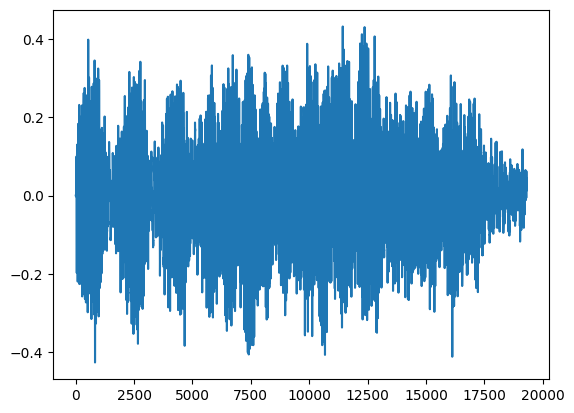

In [188]:
testing_wav_data = load_wav_16k_mono('/content/converted_audio.wav')

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

### 클래스 매핑 로드하기

YAMNet이 인식할 수 있는 클래스 이름을 로드하는 것이 중요합니다. 매핑 파일은 CSV 형식으로 `yamnet_model.class_map_path()`에 들어 있습니다.

In [159]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
Baby cry, infant cry
Whimper
Wail, moan
Sigh
Singing
Choir
Yodeling
Chant
Mantra
Child singing
Synthetic singing
Rapping
Humming
Groan
Grunt
Whistling
Breathing
Wheeze
Snoring
Gasp
Pant
Snort
Cough
Throat clearing
Sneeze
Sniff
Run
Shuffle
Walk, footsteps
Chewing, mastication
Biting
Gargling
Stomach rumble
Burping, eructation
Hiccup
Fart
Hands
Finger snapping
Clapping
Heart sounds, heartbeat
Heart murmur
Cheering
Applause
Chatter
Crowd
Hubbub, speech noise, speech babble
Children playing
Animal
Domestic animals, pets
Dog
Bark
Yip
Howl
Bow-wow
Growling
Whimper (dog)
Cat
Purr
Meow
Hiss
Caterwaul
Livestock, farm animals, working animals
Horse
Clip-clop
Neigh, whinny
Cattle, bovinae
Moo
Cowbell
Pig
Oink
Goat
Bleat
Sheep
Fowl
Chicken, rooster
Cluck
Crowi

### 추론 실행

YAMNet은 프레임 수준의 클래스 점수(즉, 모든 프레임에 대해 521점)를 제공합니다. 클립 레벨 예측을 결정하기 위해 전체 프레임에 걸쳐 클래스별로 점수를 집계할 수 있습니다(예: 평균 또는 최대 집계 사용). 이 작업을 위해 아래에서 `scores_np.mean(axis=0)`이 사용됩니다. 마지막으로, 클립 수준에서 최고 점수의 클래스를 찾으려면 521개의 집계 점수 중 최대값을 취합니다.


In [160]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


참고: 모델은 동물 소리를 올바르게 추론했습니다. 이 튜토리얼의 목표는 특정 클래스에 대한 모델의 정확도를 높이는 것입니다. 또한 모델은 프레임당 1개씩 13개의 임베딩을 생성했습니다.

## ESC-50 데이터세트

[ESC-50 데이터세트](https://github.com/karolpiczak/ESC-50#repository-content)([Piczak, 2015](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf))는 5초 길이의 환경 오디오 녹음 2,000개의 레이블이 지정된 컬렉션입니다. 데이터세트는 50개의 클래스로 구성되며 클래스당 40개의 예제가 있습니다.

데이터세트를 다운로드하고 압축을 풉니다.


In [161]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

### 데이터 살펴보기

각 파일의 메타데이터는 `./datasets/ESC-50-master/meta/esc50.csv`의 csv 파일에 지정됩니다.

그리고 모든 오디오 파일은 `./datasets/ESC-50-master/audio/`에 있습니다.

매핑을 사용하여 pandas `DataFrame`을 만들고 이를 사용하여 데이터를 더 명확하게 볼 수 있습니다.


In [162]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### 데이터 필터링

이제 데이터가 `DataFrame`에 저장되었으므로 몇 가지 변환을 적용합니다.

- 행을 필터링하고 선택한 클래스(`dog` 및 `cat`)만 사용합니다. 다른 클래스를 사용하려면 여기에서 선택할 수 있습니다.
- 전체 경로를 갖도록 파일 이름을 수정합니다. 이렇게 하면 나중에 더 쉽게 로드할 수 있습니다.
- 대상을 특정 범위 내로 변경합니다. 이 예에서 `dog`는 `0`으로 유지되지만 `cat`은 원래 값 `5` 대신 `1`이 됩니다.

In [163]:
my_classes = ['car_horn', 'engine', 'train']
map_class_to_id = {'car_horn':0, 'engine':1, 'train':2}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
28,./datasets/ESC-50-master/audio/1-119125-A-45.wav,1,2,train,False,119125,A
53,./datasets/ESC-50-master/audio/1-17124-A-43.wav,1,0,car_horn,False,17124,A
74,./datasets/ESC-50-master/audio/1-18527-A-44.wav,1,1,engine,False,18527,A
75,./datasets/ESC-50-master/audio/1-18527-B-44.wav,1,1,engine,False,18527,B
83,./datasets/ESC-50-master/audio/1-19026-A-43.wav,1,0,car_horn,False,19026,A
116,./datasets/ESC-50-master/audio/1-22882-A-44.wav,1,1,engine,False,22882,A
124,./datasets/ESC-50-master/audio/1-24074-A-43.wav,1,0,car_horn,False,24074,A
125,./datasets/ESC-50-master/audio/1-24076-A-43.wav,1,0,car_horn,False,24076,A
130,./datasets/ESC-50-master/audio/1-254507-A-43.wav,1,0,car_horn,False,254507,A
137,./datasets/ESC-50-master/audio/1-26176-A-43.wav,1,0,car_horn,False,26176,A


### 오디오 파일 로드 및 임베딩 가져오기

여기에서 `load_wav_16k_mono`를 적용하고 모델에 대한 WAV 데이터를 준비합니다.

WAV 데이터에서 임베딩을 추출할 때 형상의 배열 `(N, 1024)`을 가져옵니다. 여기서 `N`은 YAMNet이 찾은 프레임 수입니다(오디오 0.48초마다 하나씩).

모델은 각 프레임을 하나의 입력으로 사용합니다. 따라서 행당 하나의 프레임이 있는 새 열을 만들어야 합니다. 또한 이러한 새 행을 적절하게 반영하려면 레이블과 `fold` 열을 확장해야 합니다.

확장된 `fold` 열은 원래 값을 유지합니다. 분할을 수행할 때 서로 다른 분할에 동일한 오디오의 일부가 있게 되어 유효성 검사 및 테스트 단계의 효율성이 떨어질 수 있으므로 프레임을 혼합할 수 없습니다.

In [164]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [165]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [166]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### 데이터 분할

`fold` 열을 사용하여 데이터세트를 학습, 유효성 검증 및 테스트세트로 분할합니다.

ESC-50은 5개의 균일한 크기의 교차 유효성 검증 `fold`로 배열되어 동일한 원본 소스의 클립이 항상 동일한 `fold`에 있도록 합니다. 자세한 내용은 [ESC: Dataset for Environmental Sound Classification](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf) 문서를 참조하세요.

마지막 단계는 훈련 중에 사용하지 않을 것이므로 데이터세트에서 `fold` 열을 제거하는 것입니다.


In [167]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## 모델 생성하기

대부분의 작업이 끝났습니다! 다음으로, 하나의 숨겨진 레이어와 두 개의 출력을 사용하여 소리에서 고양이와 개를 인식하는 매우 간단한 [순차](https://www.tensorflow.org/guide/keras/sequential_model) 모델을 정의합니다.


In [168]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 526,339
Trainable params: 526,339
Non-trainable params: 0
_________________________________________________________________


In [169]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [170]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
23/23 [==============================] - 18s 19ms/step - loss: 0.5157 - accuracy: 0.8514 - val_loss: 0.2804 - val_accuracy: 0.9083
Epoch 2/20
23/23 [==============================] - 0s 6ms/step - loss: 0.2412 - accuracy: 0.9389 - val_loss: 0.1730 - val_accuracy: 0.9083
Epoch 3/20
23/23 [==============================] - 0s 6ms/step - loss: 0.2868 - accuracy: 0.9431 - val_loss: 0.3690 - val_accuracy: 0.9250
Epoch 4/20
23/23 [==============================] - 0s 7ms/step - loss: 0.2426 - accuracy: 0.9583 - val_loss: 0.9812 - val_accuracy: 0.9250
Epoch 5/20
23/23 [==============================] - 0s 7ms/step - loss: 0.2242 - accuracy: 0.9667 - val_loss: 0.5358 - val_accuracy: 0.9125
Epoch 6/20
23/23 [==============================] - 0s 6ms/step - loss: 0.0984 - accuracy: 0.9806 - val_loss: 0.2004 - val_accuracy: 0.8875
Epoch 7/20
23/23 [==============================] - 0s 6ms/step - loss: 0.1430 - accuracy: 0.9778 - val_loss: 0.5622 - val_accuracy: 0.9042
Epoch 8/20
23/23 [

과적합이 없는지 확인하기 위해 테스트 데이터에 대해 `evaluate` 메서드를 실행해 보겠습니다.

In [171]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

8/8 [==============================] - 0s 5ms/step - loss: 0.1229 - accuracy: 0.9833
Loss:  0.12292487174272537
Accuracy:  0.9833333492279053


훌륭합니다!

## 모델 테스트하기

다음으로, YAMNet만 사용하여 이전 테스트의 임베딩에 대해 모델을 시도합니다.


In [172]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: car_horn


## WAV 파일을 직접 입력으로 받을 수 있는 모델 저장하기

임베딩을 입력으로 제공하면 모델이 작동합니다.

실제 시나리오에서는 오디오 데이터를 직접 입력으로 사용해야 할 것입니다.

이렇게 하려면 YAMNet과 모델을 다른 애플리케이션을 위해 내보낼 수 있는 단일 모델로 결합합니다.

모델의 결과를 더 쉽게 사용할 수 있도록 최종 레이어는 `reduce_mean` 연산이 됩니다. 제공을 위해 이 모델을 사용할 때(튜토리얼 뒷부분에서 알아볼 예정) 최종 레이어의 이름이 필요합니다. 이를 정의하지 않으면 TensorFlow가 증분시키면서 이름을 자동으로 지정하는데, 그러면 모델을 훈련할 때마다 이름이 계속 달라지므로 테스트하기가 어려워집니다. 원시 TensorFlow 작업을 사용할 때는 이름을 할당할 수 없습니다. 이 문제를 해결하기 위해 `reduce_mean`을 적용하고 `'classifier'`라고 부르는 사용자 지정 레이어를 생성합니다.


In [173]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [191]:
saved_model_path = './gist_aiot.model'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

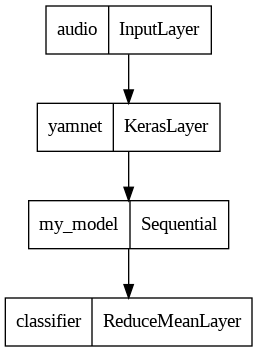

In [192]:
tf.keras.utils.plot_model(serving_model)

저장된 모델을 로드하여 예상대로 작동하는지 확인합니다.

In [193]:
reloaded_model = tf.saved_model.load(saved_model_path)

그리고 최종 테스트로... 일부 사운드 데이터가 주어지면 모델이 올바른 결과를 반환합니까?

In [177]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

The main sound is: car_horn


서비스 제공 설정에서 새 모델을 시도하려면 'serving_default' 서명을 사용할 수 있습니다.

In [178]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')


The main sound is: car_horn


## (선택 사항) 몇 가지 추가 테스트

모델이 준비되었습니다.

테스트 데이터세트에서 이를 YAMNet과 비교해 보겠습니다.

./datasets/ESC-50-master/audio/5-197121-A-45.wav
Waveform values: [ 5.9590957e-07 -1.9300853e-06  4.5873176e-06 ...  2.0359118e-02
  2.8787151e-02  3.8852930e-02]


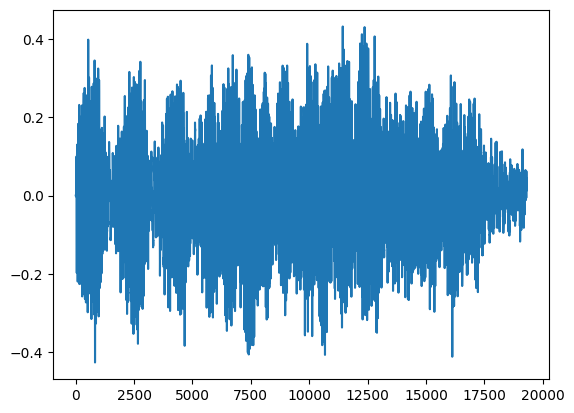

In [189]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono('/content/converted_audio.wav')
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [190]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Emergency vehicle (0.6098859906196594)
[Your model] The main sound is: car_horn (0.9992486834526062)


## 다음 단계

개나 고양이의 소리를 분류할 수 있는 모델을 만들었습니다. 같은 아이디어와 다른 데이터세트를 사용하여 예를 들어, 새의 지저귐을 바탕으로 [새의 음향 식별자](https://www.kaggle.com/c/birdclef-2021/)를 구축해 볼 수 있습니다.

소셜 미디어에서 TensorFlow 팀과 자신의 프로젝트를 공유하세요!
